In [ ]:
import pandas as pd
import numpy as np
import re
import os
import torch
from transformers import AutoTokenizer, AutoModel, Trainer, TrainingArguments, EarlyStoppingCallback, DataCollatorWithPadding
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from torch.utils.data import Dataset
import seaborn as sns

In [ ]:
df = pd.read_csv("full_dataset.csv")
df

,Facts,Type,Encoded_Label
0,تتلخص وقائع هذه ال دعوى في أن ه تقدم إلى ال مح...,الاجاره,0
1,تتلخص وقائع هذه ال دعوى ب ال قدر ال لازم ل إصد...,البيع,0
2,تتلخص وقائع ال دعوى ب ال قدر ال لازم ل إصدار ا...,الاجاره,1
3,تتلخص وقائع هذه ال دعوى في أن ال مدعي يطلب إيد...,البيع,1
4,فقد ورد ل ال دائر ة قرار دائر ة ال استئناف ال ...,البيع,0
...,...,...,...
19817,تتحصل وقائع هذه ال قضي ة ب ال قدر ال لازم ل إص...,نظر الدعوى,0
19818,تتحصل وقائع هذه ال دعوى ب ال قدر ال لازم ل إصد...,نظر الدعوى,1
19819,تتحصل وقائع هذه ال دعوى ب ال قدر ال لازم ل إصد...,نظر الدعوى,1
19820,تتحصل وقائع هذه ال دعوى حسبما تفحص ال أوراق في...,نظر الدعوى,1


In [ ]:
model_name = "aubmindlab/bert-base-arabertv2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
df["Encoded_Label"].isna().sum()

np.int64(0)

In [ ]:
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["Encoded_Label"])
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42, stratify=train_val_df["Encoded_Label"])

In [ ]:
class LegalDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=512,
                 text_col="Facts", label_col="Encoded_Label"):
        self.data = dataframe.dropna(subset=[text_col, label_col]).reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.text_col = text_col
        self.label_col = label_col

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text  = str(self.data.loc[index, self.text_col])
        label = int(self.data.loc[index, self.label_col])


        enc = self.tokenizer(
            text,
            max_length=self.max_len,  
            truncation=True,
            padding=False,             
            return_attention_mask=True,
            return_tensors=None
        )

        return {
            "input_ids": enc["input_ids"],
            "attention_mask": enc["attention_mask"],
            "labels": label
        }

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, pad_to_multiple_of=16)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_dataset = LegalDataset(train_df, tokenizer, max_len=512)
val_dataset = LegalDataset(val_df, tokenizer, max_len=512)
test_dataset = LegalDataset(test_df, tokenizer, max_len=512)

In [ ]:
def print_dataset_details(dataset, name):
    print(f"\n{name} Dataset Details:")
    print(f"Number of samples: {len(dataset)}")
    print("\nSample from dataset:")
    sample = dataset[0]  
    print(f"Input IDs: {sample['input_ids']}")
    print(f"Attention Mask: {sample['attention_mask']}")
    print(f"Label: {sample['labels']}")
    print(f"Decoded Text: {tokenizer.decode(sample['input_ids'], skip_special_tokens=True)}")


print_dataset_details(train_dataset, "Train")
print_dataset_details(val_dataset, "Validation")
print_dataset_details(test_dataset, "Test")


Train Dataset Details:
Number of samples: 12685

Sample from dataset:
Input IDs: [33, 29785, 5334, 405, 288, 3903, 140, 288, 971, 288, 2325, 162, 2451, 387, 288, 970, 140, 1074, 2549, 288, 6914, 141, 9500, 159, 2201, 413, 3811, 288, 50211, 307, 130, 1242, 288, 2545, 141, 288, 712, 141, 1605, 130, 140, 3580, 288, 1385, 141, 1605, 29451, 14678, 14037, 11334, 130, 140, 405, 288, 3903, 166, 289, 2333, 1008, 298, 3969, 142, 288, 1925, 141, 162, 298, 288, 1464, 141, 288, 8840, 141, 289, 466, 6448, 55043, 165, 166, 289, 298, 2234, 2549, 288, 6914, 141, 9500, 159, 2201, 413, 3811, 288, 50211, 307, 2545, 141, 712, 141, 1605, 140, 3580, 288, 1385, 141, 1605, 29451, 14678, 14037, 11334, 166, 462, 23946, 1235, 288, 9406, 421, 298, 347, 290, 2357, 298, 946, 2970, 298, 140, 2403, 405, 288, 1464, 141, 140, 3580, 3227, 141, 288, 13130, 1605, 40621, 10144, 55867, 130, 166, 3241, 288, 1925, 141, 336, 302, 298, 1044, 142, 405, 288, 1464, 141, 288, 8840, 141, 1084, 306, 288, 1644, 141, 288, 2759, 308, 29

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_score": f1_score(labels, preds, average="weighted"),  
    }


training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",       
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=8,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    fp16=True,
    warmup_ratio=0.06,
    metric_for_best_model="eval_loss",  
    greater_is_better=False,
    report_to=["none"],
    seed=42,
)

In [ ]:
trainer = Trainer(
    model=model,                       
    args=training_args,
    train_dataset=train_dataset,      
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  
)

/tmp/ipython-input-3881779249.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
train_output = trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 31}.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,0.452500,0.472331,0.781526,0.780215
2,0.507200,0.454065,0.796974,0.796481
3,0.504400,0.443521,0.785624,0.783767
4,0.363700,0.466113,0.793821,0.793807
5,0.261200,0.580479,0.796343,0.796331


In [ ]:
test_results = trainer.evaluate(test_dataset)

In [ ]:
test_results

{'eval_loss': 0.44946780800819397,
 'eval_accuracy': 0.7871374527112232,
 'eval_f1_score': 0.785470650132402,
 'eval_runtime': 18.9717,
 'eval_samples_per_second': 208.995,
 'eval_steps_per_second': 13.072,
 'epoch': 5.0}

In [ ]:
for k, v in test_results.items():
    if isinstance(v, (int, float)):
        print(f"{k}: {v:.4f}")

eval_loss: 0.4495
eval_accuracy: 0.7871
eval_f1_score: 0.7855
eval_runtime: 18.9717
eval_samples_per_second: 208.9950
eval_steps_per_second: 13.0720
epoch: 5.0000


In [ ]:
print("Test size:", len(test_dataset))
test_results = trainer.evaluate(test_dataset)
print(test_results)

Test size: 3965


{'eval_loss': 0.47499075531959534, 'eval_accuracy': 0.783858764186633, 'eval_f1_score': 0.7830472544748899, 'eval_runtime': 21.5796, 'eval_samples_per_second': 183.738, 'eval_steps_per_second': 11.492, 'epoch': 4.0}


              precision    recall  f1-score   support

           0     0.8487    0.6989    0.7666      1983
           1     0.7440    0.8754    0.8044      1982

    accuracy                         0.7871      3965
   macro avg     0.7964    0.7872    0.7855      3965
weighted avg     0.7964    0.7871    0.7855      3965



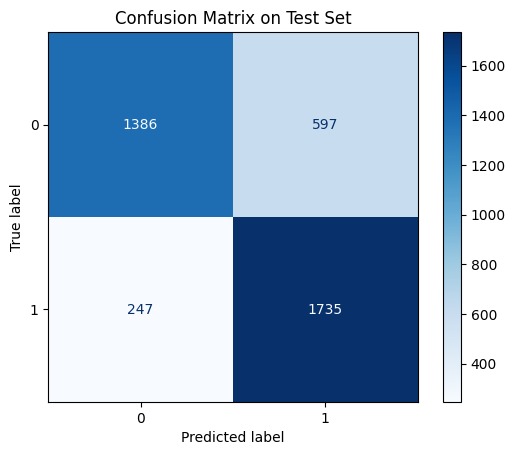

In [ ]:
preds_output = trainer.predict(test_dataset)
logits = preds_output.predictions
y_true = preds_output.label_ids
y_pred = np.argmax(logits, axis=1)

print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix on Test Set")
plt.show()

In [ ]:
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="weighted")
prec = precision_score(y_true, y_pred, average="weighted")
rec  = recall_score(y_true, y_pred, average="weighted")

print(f"Accuracy : {acc:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")

Accuracy : 0.7871
F1-score : 0.7855
Precision: 0.7964
Recall   : 0.7871


In [ ]:
df

,Facts,Type,Encoded_Label
0,تتلخص وقائع هذه ال دعوى في أن ه تقدم إلى ال مح...,الاجاره,0
1,تتلخص وقائع هذه ال دعوى ب ال قدر ال لازم ل إصد...,البيع,0
2,تتلخص وقائع ال دعوى ب ال قدر ال لازم ل إصدار ا...,الاجاره,1
3,تتلخص وقائع هذه ال دعوى في أن ال مدعي يطلب إيد...,البيع,1
4,فقد ورد ل ال دائر ة قرار دائر ة ال استئناف ال ...,البيع,0
...,...,...,...
19817,تتحصل وقائع هذه ال قضي ة ب ال قدر ال لازم ل إص...,نظر الدعوى,0
19818,تتحصل وقائع هذه ال دعوى ب ال قدر ال لازم ل إصد...,نظر الدعوى,1
19819,تتحصل وقائع هذه ال دعوى ب ال قدر ال لازم ل إصد...,نظر الدعوى,1
19820,تتحصل وقائع هذه ال دعوى حسبما تفحص ال أوراق في...,نظر الدعوى,1


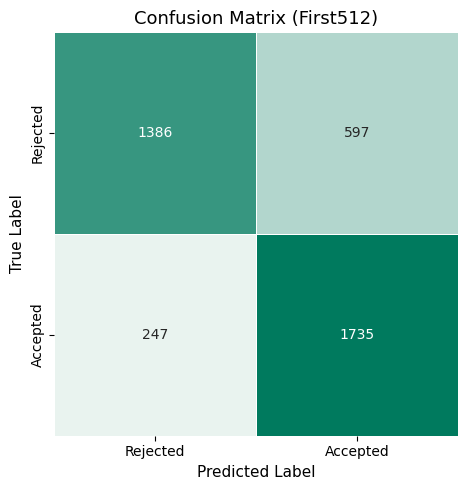

In [ ]:
class_labels = ["Rejected", "Accepted"]

def map_if_numeric(series):
    if pd.api.types.is_numeric_dtype(series):
        return pd.Series(series).map({0: "Rejected", 1: "Accepted"})
    return series

y_true_named = map_if_numeric(y_true)
y_pred_named = map_if_numeric(y_pred)


green_colors = sns.light_palette("#007A5E", as_cmap=True)


cm = confusion_matrix(y_true_named, y_pred_named, labels=class_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,        
    fmt="d",           
    cmap=green_colors, 
    xticklabels=class_labels,
    yticklabels=class_labels,
    cbar=False,
    linewidths=0.5,
    linecolor="white",
    square=True
)

plt.title("Confusion Matrix (First512)", fontsize=13)
plt.xlabel("Predicted Label", fontsize=11)
plt.ylabel("True Label", fontsize=11)

plt.tight_layout()
plt.savefig("confusion_matrix(First512).png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
test_results_df = test_df.copy()
test_results_df["True_Label"] = y_true
test_results_df["Predicted_Label"] = y_pred

In [ ]:
test_results_df

,Facts,Type,Encoded_Label,True_Label,Predicted_Label
16954,تتحصل وقائع هذه ال قضي ة ب ال قدر ال لازم ل إص...,نظر الدعوى,0,0,0
10708,تتلخص وقائع هذه ال دعوى في أن ه سبق أن تقدم ال...,نظر الدعوى,0,0,0
10347,تتلخص ال دعوى ب ال قدر ال لازم ل ال فصل في ها ...,الاجاره,1,1,1
9603,تتلخص وقائع هذه ال دعوى في أن ه سبق أن تقدم مم...,الاجاره,1,1,1
4940,تتلخص وقائع هذه ال دعوى ب ال قدر ال لازم ل إصد...,البيع,0,0,1
...,...,...,...,...,...
7268,تتلخص وقائع هذه ال دعوى في أن ه سبق أن تقدم ت ...,الاجاره,0,0,1
16371,تتلخص وقائع ال دعوى ب ال قدر ال لازم ل ال فصل ...,نظر الدعوى,0,0,0
6205,تتحصل وقائع هذه ال دعوى ب ال قدر ال لازم ل إصد...,الاجاره,1,1,1
9511,تتحصل وقائع هذه ال دعوى ب ال قدر ال كافي ل إصد...,الاجاره,1,1,1


In [ ]:
probs = torch.softmax(torch.tensor(logits), dim=1).numpy()
test_results_df["Prob_0"] = probs[:,0]
test_results_df["Prob_1"] = probs[:,1]


In [ ]:
test_results_df

,Facts,Type,Encoded_Label,True_Label,Predicted_Label,Prob_0,Prob_1
16954,تتحصل وقائع هذه ال قضي ة ب ال قدر ال لازم ل إص...,نظر الدعوى,0,0,0,0.958148,0.041852
10708,تتلخص وقائع هذه ال دعوى في أن ه سبق أن تقدم ال...,نظر الدعوى,0,0,0,0.985172,0.014828
10347,تتلخص ال دعوى ب ال قدر ال لازم ل ال فصل في ها ...,الاجاره,1,1,1,0.062732,0.937268
9603,تتلخص وقائع هذه ال دعوى في أن ه سبق أن تقدم مم...,الاجاره,1,1,1,0.094845,0.905155
4940,تتلخص وقائع هذه ال دعوى ب ال قدر ال لازم ل إصد...,البيع,0,0,1,0.338186,0.661814
...,...,...,...,...,...,...,...
7268,تتلخص وقائع هذه ال دعوى في أن ه سبق أن تقدم ت ...,الاجاره,0,0,1,0.336822,0.663178
16371,تتلخص وقائع ال دعوى ب ال قدر ال لازم ل ال فصل ...,نظر الدعوى,0,0,0,0.987640,0.012360
6205,تتحصل وقائع هذه ال دعوى ب ال قدر ال لازم ل إصد...,الاجاره,1,1,1,0.232223,0.767777
9511,تتحصل وقائع هذه ال دعوى ب ال قدر ال كافي ل إصد...,الاجاره,1,1,1,0.102754,0.897246


In [ ]:
test_results_df.to_csv("AraBERTfirst512_predictions.csv", index=False)